# Future Years

PyPSA-GB can model the GB power system  by solving a network constrained Linear Optimal Power Flow (LOPF) problem. This notebook shows the example application of a future 3 day period.

In [2]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:\\Users\\alyden\\OneDrive - University of Edinburgh\\Python\\PyPSA-GB v0.0.1\\PyPSA-GB'

In [ ]:
import pypsa
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.style.use('ggplot')
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import cartopy.crs as ccrs

import data_reader_writer

## Setting up simulation

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [3]:
# write csv files for import
start = '2040-02-28 00:00:00'
end = '2040-03-01 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour
time_step = 1.

Choose from one of the National Grid Future Energy Scenarios.

In [4]:
scenario = 'Leading The Way'
# scenario = 'Consumer Transformation'
# scenario = 'System Transformation'
# scenario = 'Steady Progression'

Choose a baseline year (from 2010-2020). The baseline year determines which historical load profile and weather dataset is used for the future year modelled. The National Grid FES modellers used 2012 as their baseline year.

In [5]:
year_baseline = 2012

data_reader_writer is a script written to read in data from the various sources and write csv files in the format required for populating a PyPSA network object

In [6]:
data_reader_writer.data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=year_baseline,
                               scenario=scenario, FES=2022, merge_generators=True, scale_to_peak=True,
                               networkmodel='Reduced', P2G=True)

In [7]:
network = pypsa.Network()
network.import_from_csv_folder('LOPF_data')

INFO:pypsa.networks:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, links, loads, storage_units


Links need to be scaled up to accomadate for future generation.

In [8]:
contingency_factor = 4
network.lines.s_max_pu *= contingency_factor

## Running the optimisation

In [9]:
network.optimize(network.snapshots, solver_name="highs")

Index(['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston',
       'Strathaven', 'Torness', 'Eccles', 'Harker', 'Stella West',
       'Penwortham', 'Deeside', 'Daines', 'Th. Marsh/Stocksbridge',
       'Thornton/Drax/Eggborough', 'Keadby', 'Ratcliffe', 'Feckenham',
       'Walpole', 'Bramford', 'Pelham', 'Sundon/East Claydon', 'Melksham',
       'Bramley', 'London', 'Kemsley', 'Sellindge', 'Lovedean', 'S.W.Penisula',
       'Netherlands', 'Belgium', 'France1', 'France2', 'Ireland', 'N. Ireland',
       'Denmark', 'Germany', 'Norway', 'Ireland2'],
      dtype='object', name='Bus')


Index(['Dinorwig', 'Ffestiniog', 'Cruachan', 'Foyers', 'Beauly Battery',
       'Peterhead Battery', 'Errochty Battery', 'Denny/Bonnybridge Battery',
       'Neilston Battery', 'Strathaven Battery',
       ...
       'Pelham P2G', 'Penwortham P2G', 'Ratcliffe P2G', 'S.W.Penisula P2G',
       'Sellindge P2G', 'Stella West P2G', 'Sundon/East Claydon P2G',
       'Th. Marsh/Stocksbridge P2G', 'Thornton/Drax/Eggborough P2G',
       'Walpole P2G'],
      dtype='object', name='StorageUnit', length=120)
Index(['BritNed', 'EastWest', 'Moyle', 'Nemo', 'IFA', 'IFA2', 'NSL',
       'ElecLink', 'Viking Link', 'Greenlink', 'GridLink', 'NeuConnect',
       'NorthConnect', 'FAB Link'],
      dtype='object', name='Link')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44

('ok', 'optimal')

## Power output by generation type

Group the generators by the carrier, and print their summed power outputs over the simulation period.

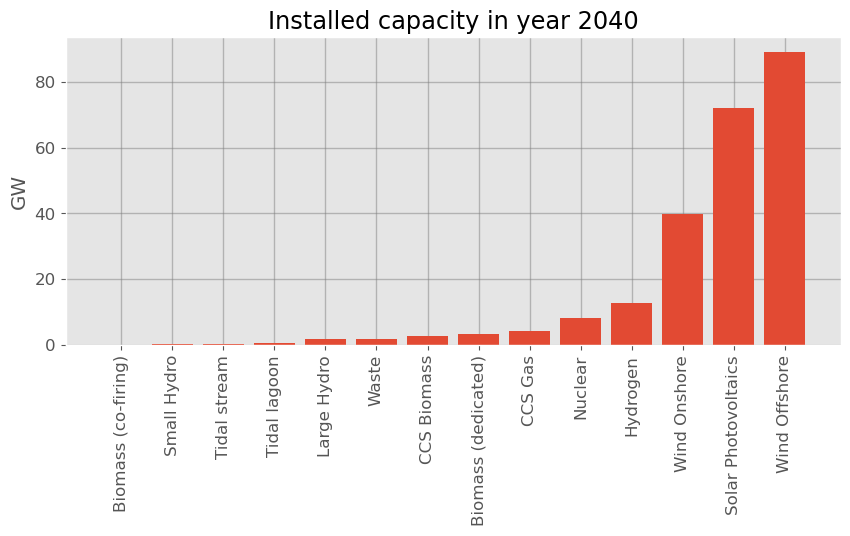

In [10]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

imp = network.links_t.p0.copy()
imp[imp < 0] = 0
imp['Interconnectors Import'] = imp.sum(axis=1)
interconnector_import = imp[['Interconnectors Import']]

p_by_carrier = pd.concat([p_by_carrier, interconnector_import], axis=1)

exp = network.links_t.p0.copy()
exp[exp > 0] = 0
exp['Interconnectors Export'] = exp.sum(axis=1)
interconnector_export = exp[['Interconnectors Export']]

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

generators_p_nom = network.generators.p_nom.groupby(
    network.generators.carrier).sum().sort_values()
if year > 2020:
    generators_p_nom.drop('Unmet Load', inplace=True)
generators_p_nom.drop(generators_p_nom[generators_p_nom < 50].index, inplace=True)

plt.rcParams.update({'font.size': 12})
# bar chart
plt.figure(figsize=(10,4))
plt.bar(generators_p_nom.index, generators_p_nom.values / 1000)
plt.xticks(generators_p_nom.index, rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('Installed capacity in year ' + str(year))
plt.show()

Graph the power output of the different generation types...

Text(0.5, 0, '')

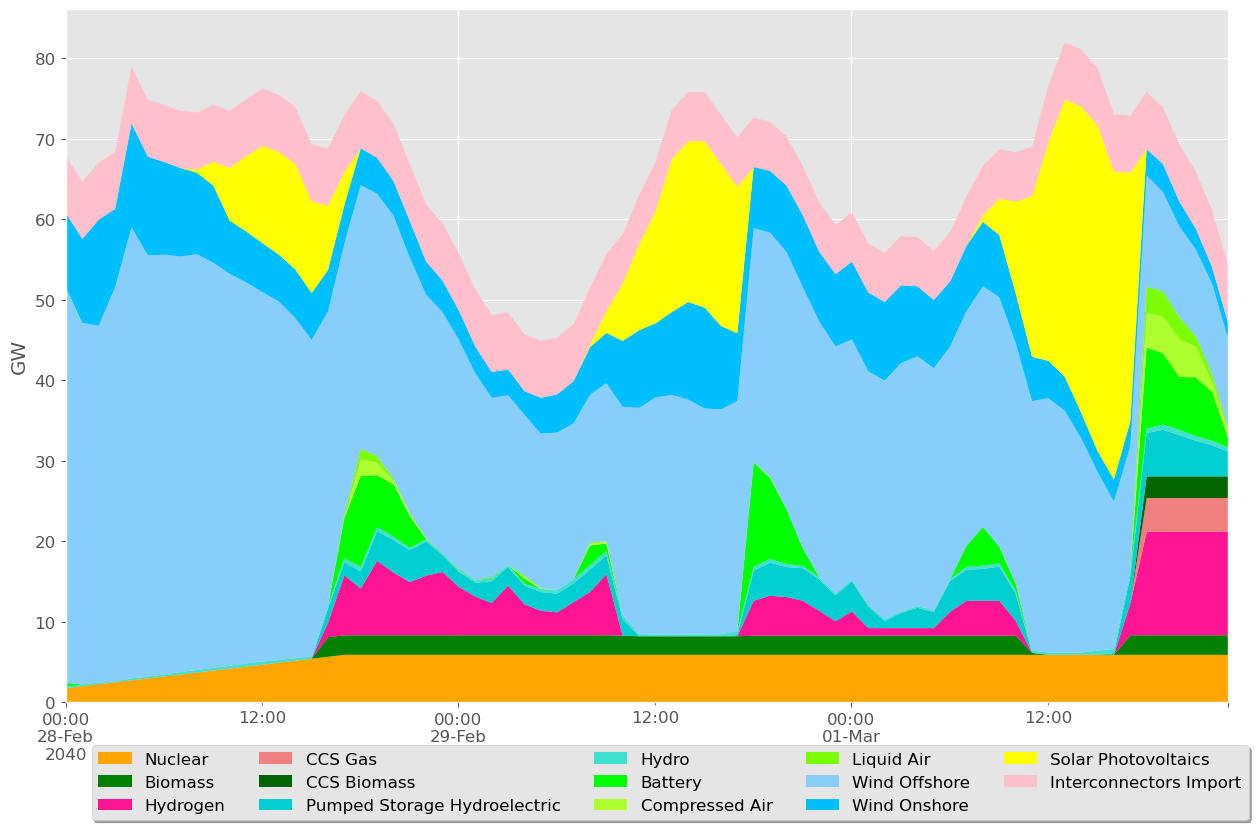

In [11]:
cols = ["Nuclear", 'Biomass',
        'Waste', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Interconnectors Import', 'Unmet Load'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)

colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          'B6 import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "deeppink",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# # stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
# (interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# # rescale the y axis
# ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.52, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

## Plotting storage

Graph the pumped hydro dispatch and state of charge...

Text(0.5, 0, '')

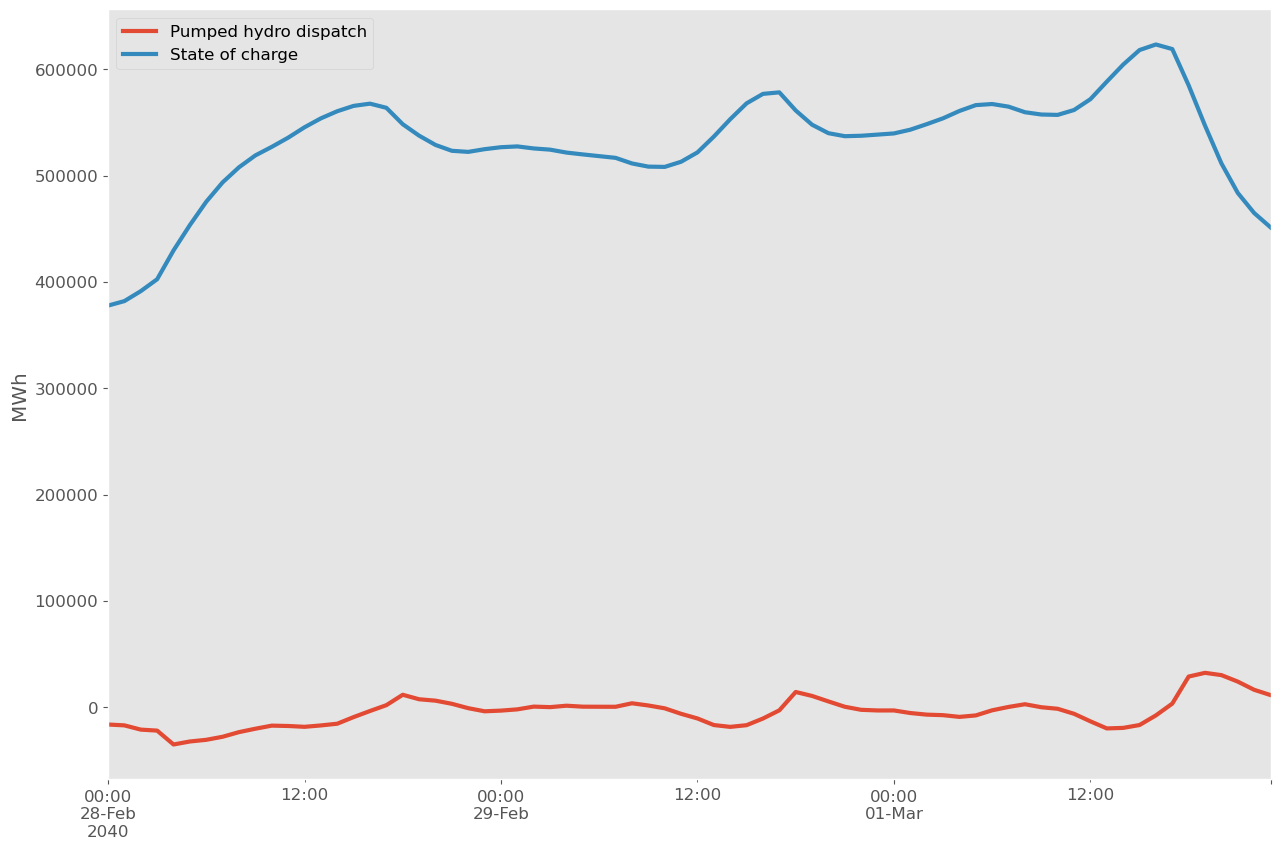

In [12]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage = network.storage_units_t.p.sum(axis=1)
state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1)
p_storage.plot(label="Pumped hydro dispatch", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")

## Plotting line loading

Look at the line loading stats and graph...

In [13]:
now = network.snapshots[60]

print("With the linear load flow, there is the following per unit loading:")
loading = network.lines_t.p0.loc[now] / network.lines.s_nom
loading.describe()

With the linear load flow, there is the following per unit loading:


count    99.000000
mean      0.376204
std       1.195151
min      -4.000000
25%      -0.111924
50%       0.193673
75%       0.543690
max       4.000000
dtype: float64

c:\Users\alyden\Anaconda3\envs\PyPSA-GB-trial2\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



(<matplotlib.collections.PatchCollection at 0x137d3de3a70>,
 <matplotlib.collections.LineCollection at 0x137d497d940>)

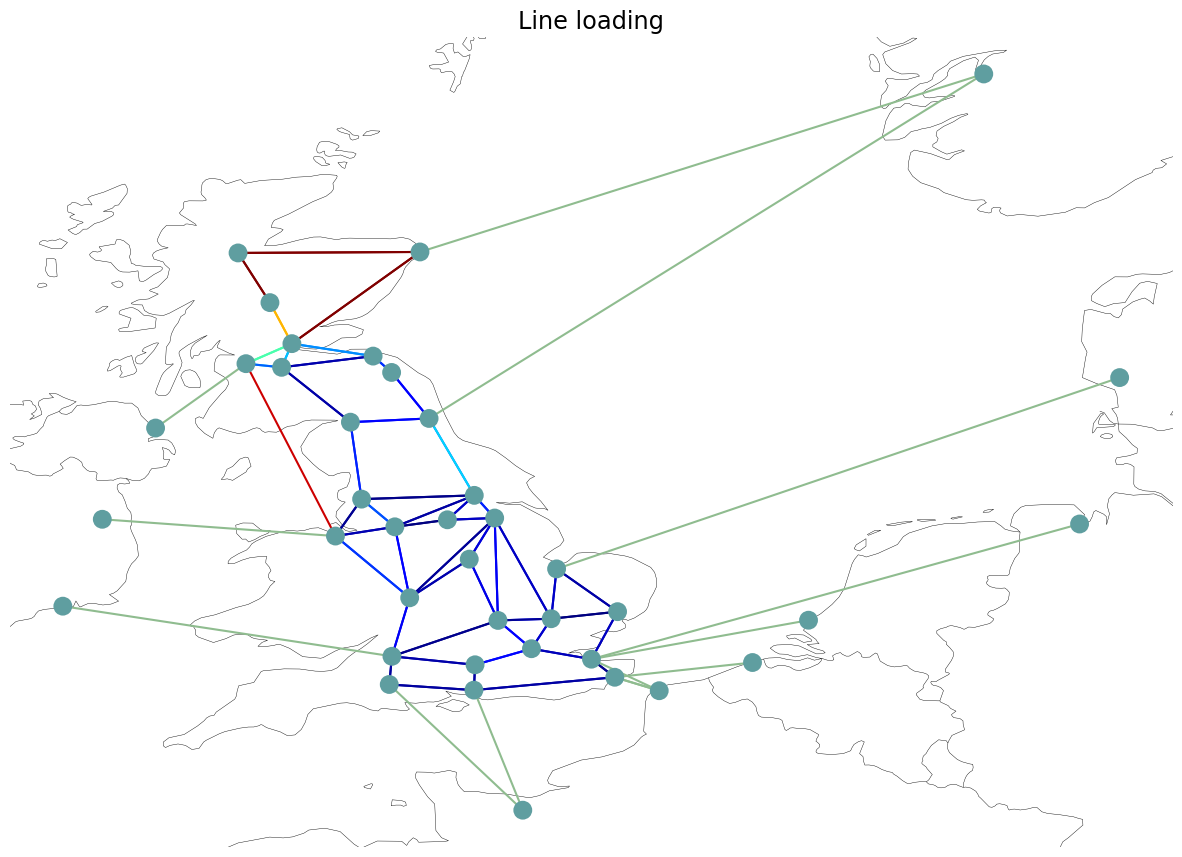

In [14]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(15, 17)

network.plot(ax=ax, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading")

## Plotting locational marginal prices

c:\Users\alyden\Anaconda3\envs\PyPSA-GB-trial2\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



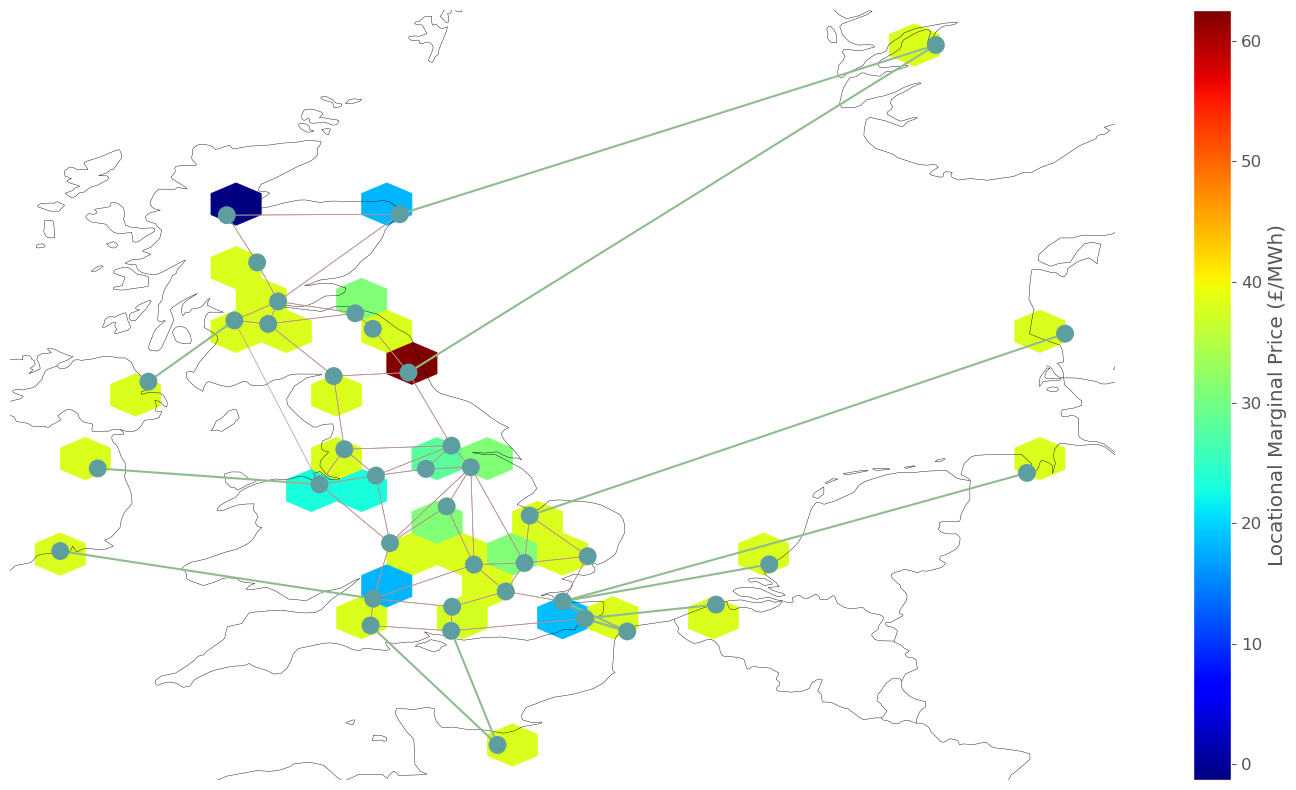

In [15]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_widths=pd.Series(0.5, network.lines.index))
plt.hexbin(network.buses.x, network.buses.y,
           gridsize=20,
           C=network.buses_t.marginal_price.loc[now],
           cmap=plt.cm.jet)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Locational Marginal Price (£/MWh)')

In [16]:
network.buses_t.marginal_price

,Beauly,Belgium,Bramford,Bramley,Daines,Deeside,Denmark,Denny/Bonnybridge,Eccles,Errochty,...,Sellindge,Stella West,Strathaven,Sundon/East Claydon,Th. Marsh/Stocksbridge,Thornton/Drax/Eggborough,Torness,Walpole,Keadby,Melksham
snapshot,,,,,,,,,,,,,,,,,,,,,
2040-02-28 00:00:00,-1.000000e+00,-21.0,-1.0,-1.0,-1.0,-1.0,-8.0,-1.0,-1.0,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2040-02-28 01:00:00,-1.000000e+00,-21.0,-1.0,-1.0,-1.0,-1.0,-8.0,-1.0,-1.0,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2040-02-28 02:00:00,-1.000000e+00,-21.0,-1.0,-1.0,-1.0,-1.0,-8.0,-1.0,-1.0,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2040-02-28 03:00:00,-1.000000e+00,-21.0,-1.0,-1.0,-1.0,-1.0,-8.0,-1.0,-1.0,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2040-02-28 04:00:00,-1.000000e+00,-21.0,-1.0,-1.0,-1.0,-1.0,-8.0,-1.0,-1.0,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040-03-01 19:00:00,-0.000000e+00,480.0,500.0,500.0,500.0,500.0,493.0,500.0,500.0,741.176471,...,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0
2040-03-01 20:00:00,-0.000000e+00,480.0,500.0,500.0,500.0,500.0,493.0,500.0,500.0,741.176471,...,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0
2040-03-01 21:00:00,-2.557954e-13,480.0,500.0,500.0,500.0,500.0,493.0,500.0,500.0,741.176471,...,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0


## Plotting curtailment

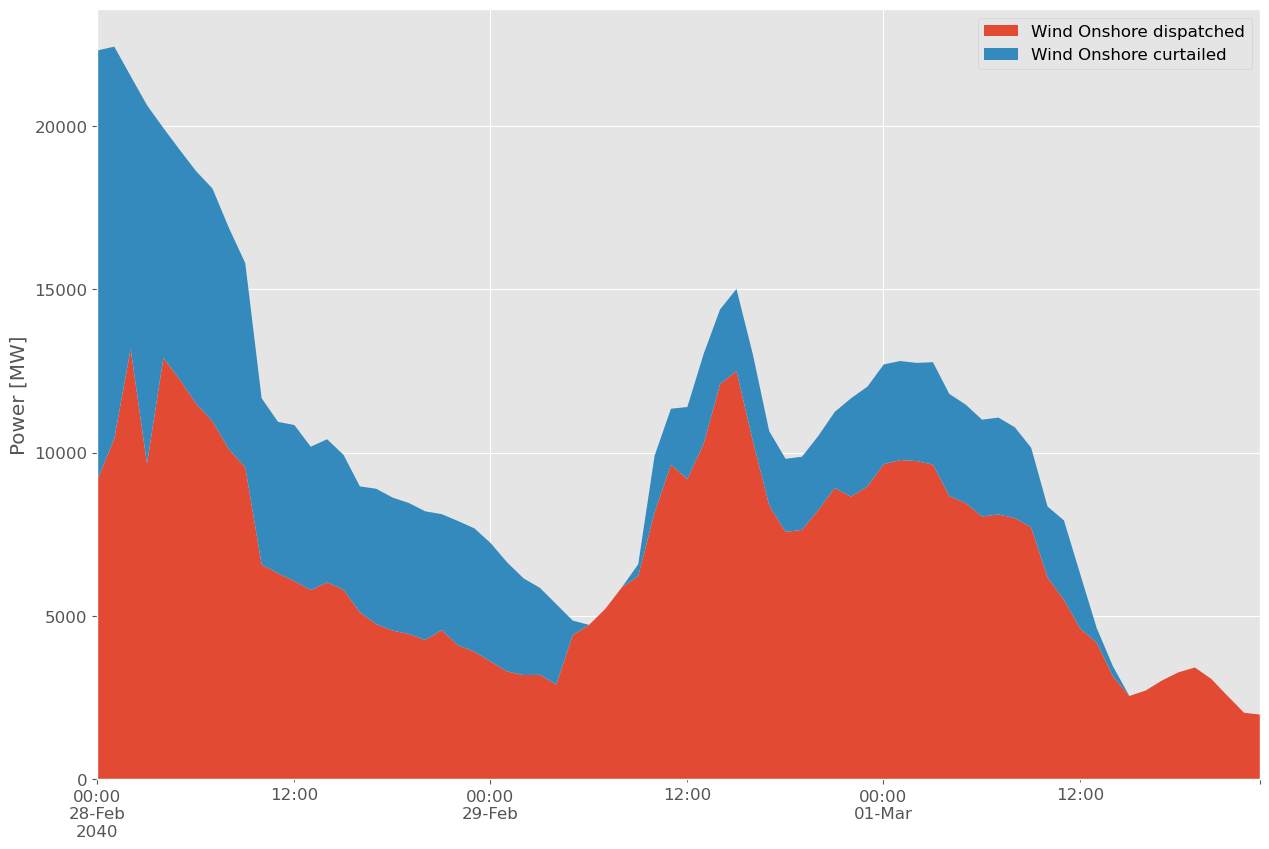

In [17]:
carrier = "Wind Onshore"

capacity = network.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = network.generators_t.p_max_pu.multiply(network.generators["p_nom"])
p_available_by_carrier = p_available.groupby(network.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier
p_df = pd.DataFrame({carrier + " available": p_available_by_carrier[carrier],
                     carrier + " dispatched": p_by_carrier[carrier],
                     carrier + " curtailed": p_curtailed_by_carrier[carrier]})

p_df[carrier + " capacity"] = capacity
p_df["Wind Onshore curtailed"][p_df["Wind Onshore curtailed"] < 0.] = 0.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(kind="area", ax=ax, linewidth=0)
# p_df[[carrier + " available", carrier + " capacity"]].plot(ax=ax, linewidth=0)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.legend()